<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  10.4 - Analysing Streaming Data with Kafka

## Introduction

**Note**: this notebook is to be run in Google Colab on your Google Drive. It will not work locally on your computer.

The purpose of this lab is to gain experience in working with streaming data, using Apache Kafka installed on Google Colaboratory (Colab). You will see how a simple streaming dashboard data is created using the JupyterDash library and simulate live model scoring in monitoring a machine learning model.

Apache Kafka is an open-source distributed publish-subscribe messaging system that maintains streams of messages in topics. It has become a highly popular streaming platform for real-time applications.

In Google Colab, a virtual machine is automatically set up to execute your code. The maximum lifetime of such a machine is 12 hours. Note that notebooks will be disconnected from virtual machines if left idle. If this happens simple click on the Connect button to reconnect. If the kernel needs to be restarted (via the Runtime menu), variables may be lost but packages would not need to be reinstalled unless a new machine is assigned.

https://research.google.com/colaboratory/faq.html

Sign into colab.research.google.com and choose the Upload tab and upload this notebook.  This will automatically create a folder called "Colab Notebooks" in your Google Drive (if it does not already exist). Next upload the dataset **"fraud_data.csv"** into this "Colab Notebooks" folder by going firstly to drive.google.com.

## Setup

The following code connects your Google Drive to this notebook. A new window will open to prompt you to allow the connection to occur.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Upon running the following cell you should see the name of this notebook and fraud_data.csv.

In [4]:
!ls "/content/gdrive/My Drive/Colab Notebooks/"

 fraud_data.csv		     'IOD_Lab-10_4-Datastraming and Kafka.ipynb'
 IOD_Lab-10_3-PySpark.ipynb   WPP2019_PopulationBySingleAgeSex_1950-2019.csv


Next download and install Kafka:

In [5]:
!curl -sSOL https://downloads.apache.org/kafka/3.4.1/kafka_2.13-3.4.1.tgz
!tar -xzf kafka_2.13-3.4.1.tgz

The kafka-python library will provide a Python-like interface to the Kafka platform:

In [6]:
!pip install kafka-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 5.3 MB/s eta 0:00:00


Finally jupyter-dash will be used for interactive plotting in this notebook:

In [7]:
!pip install jupyter-dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.9 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.6
    Uninstalling Werkzeug-2.3.6:
      Successfully uninstalled Werkzeug-2.3.6


In [8]:
import time
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from kafka import KafkaProducer
from kafka import KafkaConsumer

from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import (Input, Output)
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import re
import warnings
warnings.filterwarnings('ignore')

We use the following shell command to run Zookeeper and Kafka.

Apache ZooKeeper is used in distributed systems for service synchronisation, tracking the status of nodes in the Kafka cluster and maintaining a list of Kafka topics and messages.

In [9]:
!./kafka_2.13-3.4.1/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.4.1/config/zookeeper.properties
!./kafka_2.13-3.4.1/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.4.1/config/server.properties
!echo "Waiting until zookeeper and kafka services are ready"
!sleep 10

Waiting until zookeeper and kafka services are ready


Verify that Kafka and Zookeeper are running (you should see four lines where the first two relate to Zookeeper and Kafka):

In [10]:
!ps -ef | grep kafka

root        5098       1 13 05:59 ?        00:00:02 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-3.4.1/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-3.4.1/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-3.4.1/bin/../config/log4j.properties -cp /content/kafka_2.13-3.4.1/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-3.4.1/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-3.4.1/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-3.4.1/bin/../libs/audience-annotations-0.13.0.jar:/content/kafka_2.13-3.4.1/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-3.4.1/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.1

## Loading the dataset

The dataset fraud_data.csv represents credit card transactions which have been labelled as fraudulent or non-fraudulent. It is synthetically generated and is based on the dataset at https://www.kaggle.com/kartik2112/fraud-detection. Some of the features based on transactions in the past 24 hours or 6 months have been engineered from the raw data.

- trans_datetime - date and time of the transaction
- cc_num - credit card number of the customer
- merchant - name of the merchant to which the customer is paying
- amt: amount of the transaction in $
- first: first name of the customer
- last: last name of the customer
- gender: gender of the customer
- street, city, state: address of the customer
- zip: zip code of the transaction
- lat: latitude of the customer
- long: longitude of the customer
- city_pop: population of the city where the customer is living
- job, age: job and age of the customer
- num_trans_60d, num_trans_24h: number of transactions by this credit card in the past 60 days, 24 hours respectively
- num_fraud_trans_24h: number of fraudulent transactions by this credit card in the past 24 hours
- avg_trans_amt_60d: the average number of transactions by this credit card in the past 60 days
- is_fraud: whether the transaction is fraud or not (1 - fraud, 0 - not fraud)

In [11]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/fraud_data.csv')
df.head()

,trans_datetime,cc_num,merchant,category,amount,firstname,lastname,gender,street,city,...,lat,lon,city_pop,job,age,num_trans_60d,num_trans_24h,num_fraud_trans_24h,avg_trans_amt_60d,is_fraud
0,2019-01-01 00:14:37,2305336922781618,Harris Inc,gas_transport,50.79,Jeffrey,Rice,M,21447 Powell Circle,Moulton,...,40.6866,-92.6833,1132,Probation officer,58,1,6,0,50.79,0
1,2019-01-01 00:18:06,4428780983793657331,Lesch Ltd,shopping_pos,22.95,Richard,Waters,M,7683 Natasha Way Apt. 945,Waukesha,...,42.9993,-88.2196,95015,"Therapist, occupational",73,1,8,0,22.95,0
2,2019-01-01 00:40:50,213178850083780,Cummerata-Jones,gas_transport,70.53,Shawn,King,M,31493 Garcia Summit,Athena,...,45.8289,-118.4971,1302,Dealer,42,1,6,0,52.48,0
3,2019-01-01 00:47:55,3525668150756629,Heathcote LLC,shopping_net,101.35,Christopher,Choi,M,04611 Sandra Spring Suite 059,Rumely,...,46.3481,-87.0436,137,Film/video editor,28,424,5,0,69.34,0
4,2019-01-01 01:02:16,376028110684021,Wolf Inc,grocery_pos,89.11,Aaron,Murray,M,624 Hale Springs Apt. 572,Meadville,...,39.7795,-93.3014,964,Tourist information centre manager,44,1,3,0,66.03,0


## Perform EDA

**Exercise**: Perform some exploratory data analysis on the df dataframe.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96510 entries, 0 to 96509
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trans_datetime       96510 non-null  object 
 1   cc_num               96510 non-null  int64  
 2   merchant             96510 non-null  object 
 3   category             96510 non-null  object 
 4   amount               96510 non-null  float64
 5   firstname            96510 non-null  object 
 6   lastname             96510 non-null  object 
 7   gender               96510 non-null  object 
 8   street               96510 non-null  object 
 9   city                 96510 non-null  object 
 10  state                96510 non-null  object 
 11  zip                  96510 non-null  int64  
 12  lat                  96510 non-null  float64
 13  lon                  96510 non-null  float64
 14  city_pop             96510 non-null  int64  
 15  job                  96510 non-null 

In [13]:
df.isna()

,trans_datetime,cc_num,merchant,category,amount,firstname,lastname,gender,street,city,...,lat,lon,city_pop,job,age,num_trans_60d,num_trans_24h,num_fraud_trans_24h,avg_trans_amt_60d,is_fraud
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96505,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
96506,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
96507,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
96508,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
df.value_counts()

trans_datetime       cc_num            merchant                      category       amount  firstname    lastname    gender  street                        city               state  zip    lat      lon        city_pop  job                          age  num_trans_60d  num_trans_24h  num_fraud_trans_24h  avg_trans_amt_60d  is_fraud
2019-01-01 00:14:37  2305336922781618  Harris Inc                    gas_transport  50.79   Jeffrey      Rice        M       21447 Powell Circle           Moulton            IA     52572  40.6866  -92.6833   1132      Probation officer            58   1              6              0                    50.79              0           1
2020-05-25 20:51:55  345060451158891   Kozey-Kuhlman                 personal_care  17.90   Brian        Perez       M       78652 Scott Ports             Ashfield           MA     1330   42.5232  -72.8110   1506      Production assistant, radio  60   106            2              0                    64.58              0          

AttributeError: ignored

**Question**: How balanced is this dataset?

In [ ]:
# ANSWER


Correlation matrix:

In [15]:
df_numerical = df[['amount', 'lat', 'lon', 'city_pop', 'age', 'num_trans_60d',
                   'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d',
                   'is_fraud']]

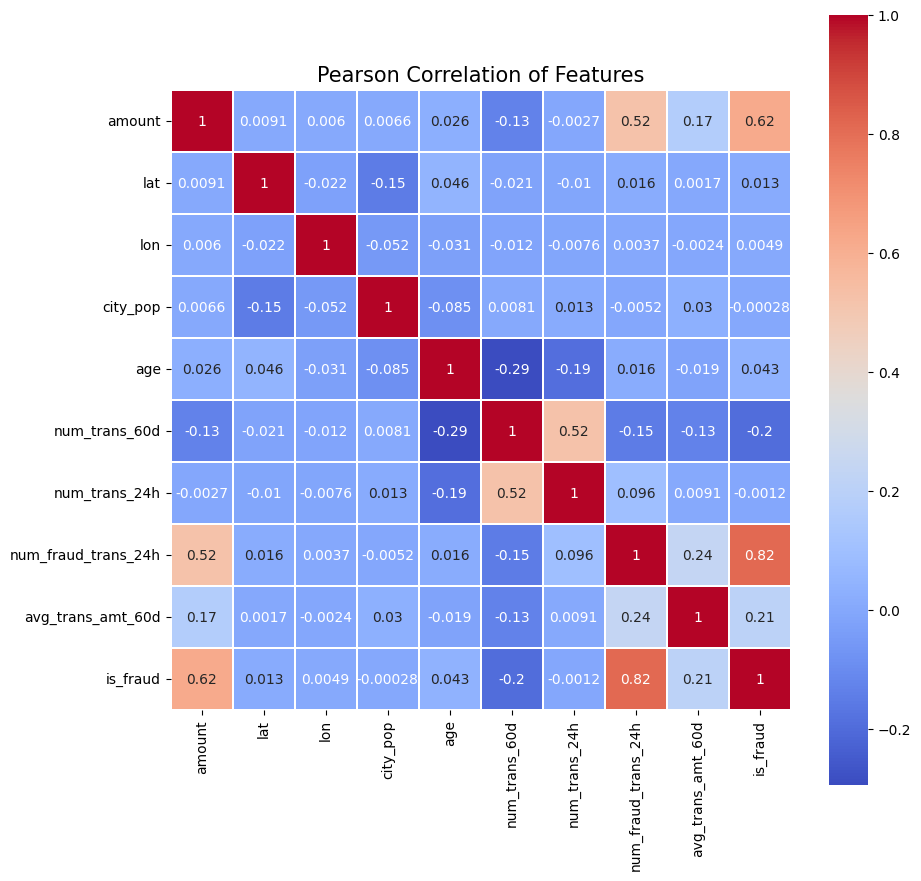

In [16]:
colormap = plt.cm.coolwarm
plt.figure(figsize = (10, 10))
plt.title('Pearson Correlation of Features', size = 15)
sns.heatmap(df_numerical.astype(float).corr(),
            linewidths = 0.1,
            vmax = 1.0,
            square = True,
            cmap = colormap,
            linecolor = 'white',
            annot = True)
plt.show()

We see that amount, num_trans_60d, num_fraud_trans_24h, and num_trans_avg_amt_60d have the strongest correlation with the target variable is_fraud.

Since the dataset is large, we sample 1000 rows to obtain a pairplot.

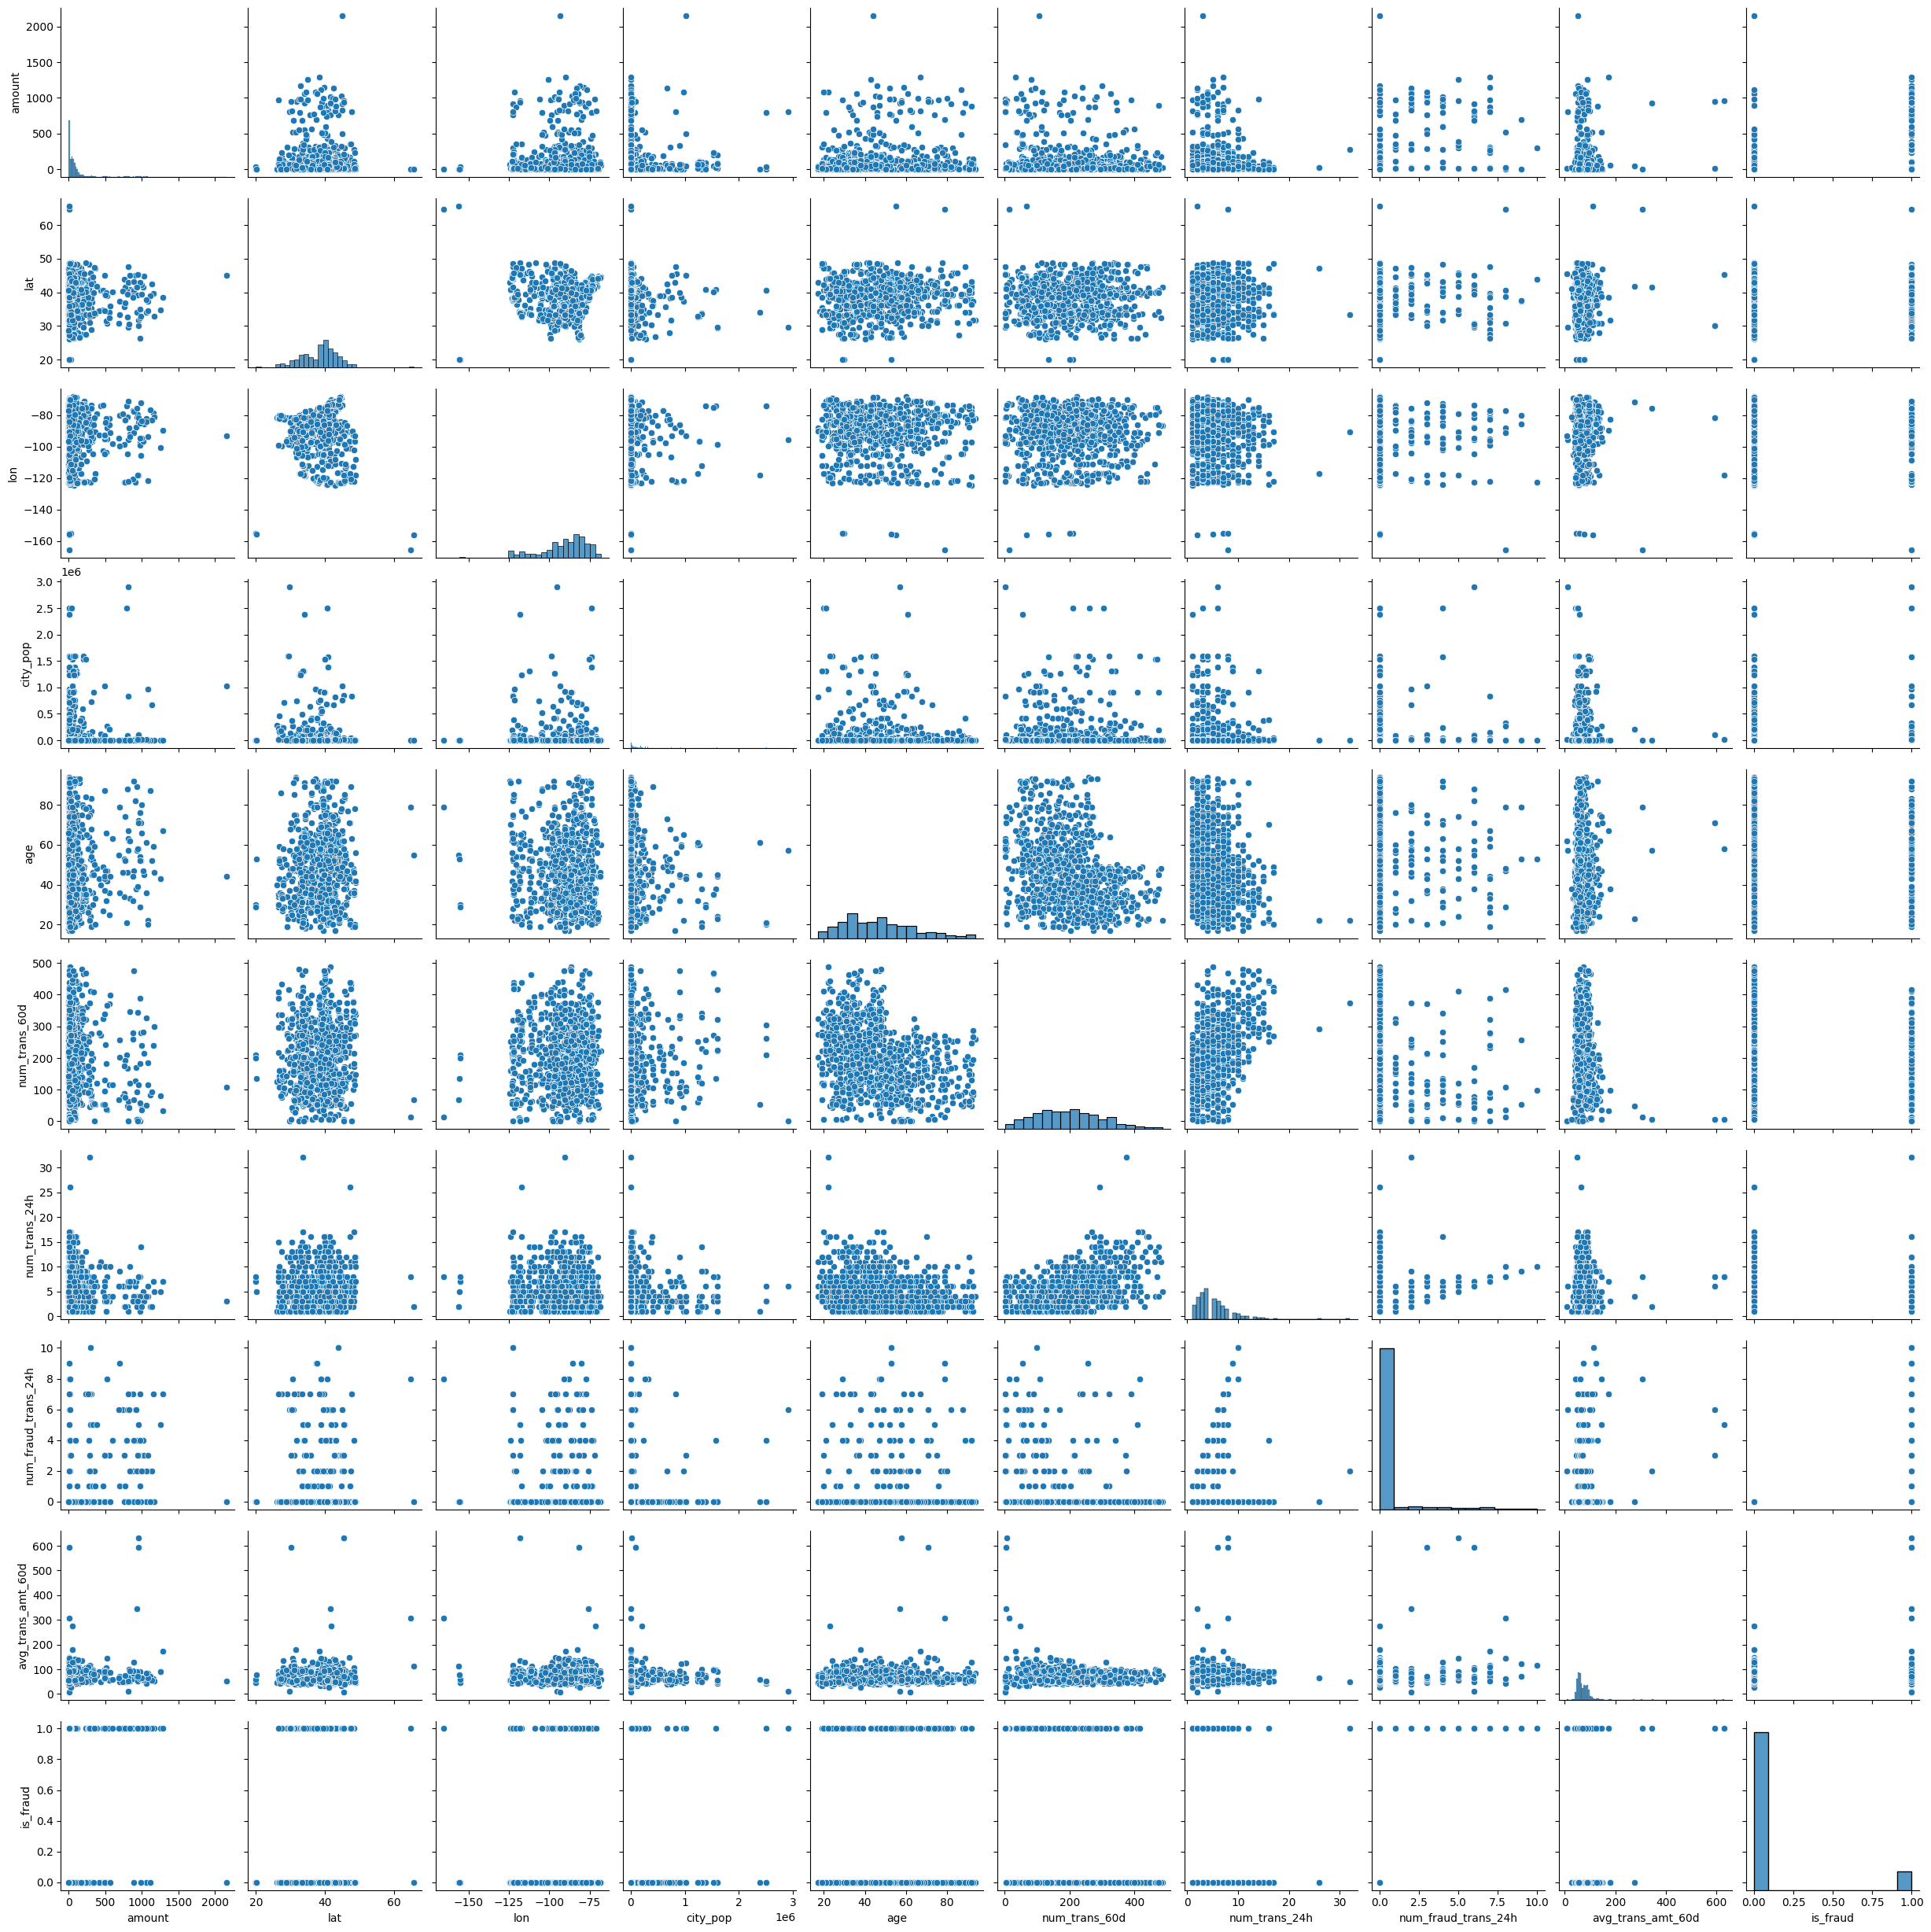

In [17]:
sns.pairplot(df_numerical.sample(1000, random_state=0))
plt.show()

## Create topics

Kafka records are stored in *topics* which can be thought of as data feeds that one can subscribe to.

We shall create two topics to the Kafka platform.  

- One with customer information (called *customerinfo*)
- One with predictors that can be used for a fraud prediction algorithm (called *features*)

In [18]:
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 2 --topic customerinfo
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic features


Created topic customerinfo.
Created topic features.


View their details:

In [19]:
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic customerinfo
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic features

Topic: customerinfo	TopicId: xpbSelttTnK96LZGD3wRqQ	PartitionCount: 2	ReplicationFactor: 1	Configs: 
	Topic: customerinfo	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
	Topic: customerinfo	Partition: 1	Leader: 0	Replicas: 0	Isr: 0
Topic: features	TopicId: kTmjym2zTIetvm4cArTC1g	PartitionCount: 1	ReplicationFactor: 1	Configs: 
	Topic: features	Partition: 0	Leader: 0	Replicas: 0	Isr: 0


Next we create the records for these topics. The records need to be a list of key-value pairs. Here we will make the key the datetime (timestamp) of the transaction.

In [20]:
timestamps = list(df['trans_datetime'][90000:].to_csv(index=False).split("\n"))
X_kafka = list(df.drop(['trans_datetime'],axis=1)[90000:].to_csv(index=False).split("\n"))


In [21]:
predictors = ['amount', 'num_trans_60d', 'num_fraud_trans_24h', 'avg_trans_amt_60d']
featuredata = list(df[predictors + ['is_fraud']][90000:].to_csv(index=False).split("\n"))

In [22]:
X_kafka

['cc_num,merchant,category,amount,firstname,lastname,gender,street,city,state,zip,lat,lon,city_pop,job,age,num_trans_60d,num_trans_24h,num_fraud_trans_24h,avg_trans_amt_60d,is_fraud',
 '377834944388609,Kuhic LLC,shopping_net,1061.02,Michael,Jackson,M,539 Underwood Divide,Pea Ridge,AR,72751,36.4539,-94.118,6434,Product designer,53,56,5,5,68.13,1',
 '639030014711,"Schumm, McLaughlin and Carter",food_dining,62.68,Stephen,Lopez,M,696 Matthew Ford Suite 157,Olmsted,IL,62970,37.1935,-89.0933,639,Mechanical engineer,38,111,5,0,92.62,0',
 '4155021259183870,Pollich LLC,home,59.16,Renee,Parrish,F,174 Jennifer Meadow Apt. 467,Mountain Park,OK,73559,34.7032,-98.9591,540,Research scientist (life sciences),37,215,12,0,61.68,0',
 '4874017206859125,"Mueller, Gerhold and Mueller",health_fitness,93.83,Lauren,Williams,F,065 Jones Stravenue,Lake Oswego,OR,97034,45.4093,-122.6847,42817,Planning and development surveyor,39,141,9,0,94.91,0',
 '3513618443244549,Streich Ltd,home,8.62,Amber,Perez,F,954 Reyes Wa

In [23]:
featuredata

['amount,num_trans_60d,num_fraud_trans_24h,avg_trans_amt_60d,is_fraud',
 '1061.02,56,5,68.13,1',
 '62.68,111,0,92.62,0',
 '59.16,215,0,61.68,0',
 '93.83,141,0,94.91,0',
 '8.62,224,0,70.26,0',
 '73.3,217,0,92.72,0',
 '9.92,188,0,85.84,0',
 '409.2,56,6,68.13,1',
 '53.29,107,0,99.47,0',
 '1.17,276,0,108.88,0',
 '21.46,158,0,58.25,0',
 '38.56,282,0,68.59,0',
 '2.24,249,0,51.68,0',
 '35.1,337,0,90.32,0',
 '7.95,232,0,62.61,0',
 '244.39,336,0,79.15,0',
 '43.25,177,0,90.78,0',
 '6.3,118,0,55.08,0',
 '3.11,283,0,43.19,0',
 '79.71,265,0,47.38,0',
 '79.34,229,0,95.37,0',
 '9.3,244,0,43.38,0',
 '54.6,152,0,51.05,0',
 '6.38,241,0,49.52,0',
 '436.63,271,0,50.39,0',
 '2.48,280,0,54.8,0',
 '77.24,215,0,94.13,0',
 '66.93,65,0,87.91,0',
 '69.43,112,0,99.0,0',
 '9.16,1,0,9.16,1',
 '71.88,289,0,53.63,0',
 '84.37,155,0,37.36,0',
 '53.54,230,0,79.18,0',
 '6.71,167,0,55.95,0',
 '183.99,58,0,55.73,0',
 '72.07,185,0,90.52,0',
 '5.48,188,0,61.51,0',
 '26.63,164,0,53.14,0',
 '104.55,111,0,124.15,0',
 '64.24,261

The following helper functions will help write messages into each topic.

In [24]:
def error_callback(exc):
    raise Exception('Error while sending data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, items):
  count=0
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  for key, message in items:
    producer.send(topic_name, key=key.encode('utf-8'),
                  value=message.encode('utf-8')).add_errback(error_callback)
    count+=1
  producer.flush()
  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

To start with we write 5 messages to each topic.

In [25]:
write_to_kafka("customerinfo", zip(timestamps[1:6], X_kafka[1:6]))
write_to_kafka("features", zip(timestamps[1:6], featuredata[1:6]))

Wrote 5 messages into topic: customerinfo
Wrote 5 messages into topic: features


The zip function pairs up the timestamps with data into tuples.

Run the following shell command to view one of the topics. You will need to interrupt execution of the cell after the five messages have appeared.

In [26]:
! /content/kafka_2.13-3.4.1/bin/kafka-console-consumer.sh \
--bootstrap-server localhost:9092 \
--topic features \
--from-beginning

1061.02,56,5,68.13,1
62.68,111,0,92.62,0
59.16,215,0,61.68,0
93.83,141,0,94.91,0
8.62,224,0,70.26,0
Processed a total of 5 messages


## Subscribing to topics
To start with we subscribe to both topics with the same consumer.

In [27]:
kafka_bootstrap_servers = 'localhost:9092'
topics = ['customerinfo', 'features']

In [28]:
consumer = KafkaConsumer(
    *topics,
    bootstrap_servers=kafka_bootstrap_servers,
    auto_offset_reset='earliest',
    enable_auto_commit=True)

In [29]:
consumer.config

{'bootstrap_servers': 'localhost:9092',
 'client_id': 'kafka-python-2.0.2',
 'group_id': None,
 'key_deserializer': None,
 'value_deserializer': None,
 'fetch_max_wait_ms': 500,
 'fetch_min_bytes': 1,
 'fetch_max_bytes': 52428800,
 'max_partition_fetch_bytes': 1048576,
 'request_timeout_ms': 305000,
 'retry_backoff_ms': 100,
 'reconnect_backoff_ms': 50,
 'reconnect_backoff_max_ms': 1000,
 'max_in_flight_requests_per_connection': 5,
 'auto_offset_reset': 'earliest',
 'enable_auto_commit': True,
 'auto_commit_interval_ms': 5000,
 'default_offset_commit_callback': <function kafka.consumer.group.KafkaConsumer.<lambda>(offsets, response)>,
 'check_crcs': True,
 'metadata_max_age_ms': 300000,
 'partition_assignment_strategy': (kafka.coordinator.assignors.range.RangePartitionAssignor,
  kafka.coordinator.assignors.roundrobin.RoundRobinPartitionAssignor),
 'max_poll_records': 500,
 'max_poll_interval_ms': 300000,
 'session_timeout_ms': 10000,
 'heartbeat_interval_ms': 3000,
 'receive_buffer_by

The following cell shows the message, key and value of records obtained by the consumer. Stop running of the cell once ten messages have been displayed.

In [30]:
for message in consumer:
  print("message: ", message)
  print("key: ", message.key)
  print("value: ", message.value.decode('utf-8'))
  time.sleep(2)

message:  ConsumerRecord(topic='customerinfo', partition=0, offset=0, timestamp=1689314554650, timestamp_type=0, key=b'2020-12-01 22:17:33', value=b'377834944388609,Kuhic LLC,shopping_net,1061.02,Michael,Jackson,M,539 Underwood Divide,Pea Ridge,AR,72751,36.4539,-94.118,6434,Product designer,53,56,5,5,68.13,1', headers=[], checksum=None, serialized_key_size=19, serialized_value_size=160, serialized_header_size=-1)
key:  b'2020-12-01 22:17:33'
value:  377834944388609,Kuhic LLC,shopping_net,1061.02,Michael,Jackson,M,539 Underwood Divide,Pea Ridge,AR,72751,36.4539,-94.118,6434,Product designer,53,56,5,5,68.13,1
message:  ConsumerRecord(topic='customerinfo', partition=1, offset=0, timestamp=1689314554651, timestamp_type=0, key=b'2020-12-01 22:23:27', value=b'639030014711,"Schumm, McLaughlin and Carter",food_dining,62.68,Stephen,Lopez,M,696 Matthew Ford Suite 157,Olmsted,IL,62970,37.1935,-89.0933,639,Mechanical engineer,38,111,5,0,92.62,0', headers=[], checksum=None, serialized_key_size=19, 

KeyboardInterrupt: ignored

**Question**: In which order have the records come into the consumer and are the records sorted within each topic?

**Answer**:

For the next section we delete and recreate our topics, this time each with one partition.

In [31]:
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --delete --bootstrap-server 127.0.0.1:9092 --topic customerinfo
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --delete --bootstrap-server 127.0.0.1:9092 --topic features


In [32]:
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic customerinfo
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic features


Created topic customerinfo.
Created topic features.


In [33]:
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic customerinfo
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic features

Topic: customerinfo	TopicId: xDPk4ZuLReOQ-Uz8X-tTFQ	PartitionCount: 1	ReplicationFactor: 1	Configs: 
	Topic: customerinfo	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: features	TopicId: dK6CggaxRUSMGkmjiREOpQ	PartitionCount: 1	ReplicationFactor: 1	Configs: 
	Topic: features	Partition: 0	Leader: 0	Replicas: 0	Isr: 0


## Creating a map showing the incoming stream

This time we write more messages to each topic.

In [34]:
write_to_kafka("customerinfo", zip(timestamps[1:], X_kafka[1:]))

Wrote 6511 messages into topic: customerinfo


**Exercise**: write featuredata[1:] to the topic "features"

In [ ]:
# ANSWER:


In [35]:
consumer = KafkaConsumer(
    'customerinfo',
    bootstrap_servers=kafka_bootstrap_servers,
    auto_offset_reset='earliest',
    enable_auto_commit=True)

Run the following cell to see if the first 20 latitude and longitude values are accessible.

In [36]:
df_received = pd.DataFrame(columns = ['lat', 'lon'])
count = 0
for message in consumer:
  count = count + 1
  x = re.split(r",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)", message.value.decode('utf-8'))
  #source: https://stackoverflow.com/questions/18893390/splitting-on-comma-outside-quotes
  #this regular expression allows one to split the record only on commas occurring outside quote
  #characters
  df_received = df_received.append({'lat': x[11], 'lon': x[12]}, ignore_index=True)
  print(f"lat = %s, lon = %s" %  (x[11], x[12]))
  #time.sleep(1)
  if count > 20:
    break

lat = 36.4539, lon = -94.118
lat = 37.1935, lon = -89.0933
lat = 34.7032, lon = -98.9591
lat = 45.4093, lon = -122.6847
lat = 43.7588, lon = -97.8712
lat = 43.0048, lon = -108.8964
lat = 43.0048, lon = -108.8964
lat = 36.4539, lon = -94.118
lat = 29.479, lon = -95.9681
lat = 43.6498, lon = -116.4306
lat = 44.3566, lon = -103.6999
lat = 47.2271, lon = -117.0819
lat = 42.9207, lon = -91.0685
lat = 46.0062, lon = -86.2555
lat = 40.5891, lon = -75.4645
lat = 26.4215, lon = -99.0025
lat = 39.7532, lon = -105.6356
lat = 27.5517, lon = -81.8074
lat = 40.4603, lon = -79.0097
lat = 33.4629, lon = -86.7904
lat = 39.0965, lon = -84.6431


Another way of getting records from the consumer is through the poll method:

In [37]:
latestrecord = consumer.poll(max_records = 1)

In [38]:
latestrecord

{TopicPartition(topic='customerinfo', partition=0): [ConsumerRecord(topic='customerinfo', partition=0, offset=5159, timestamp=1689314759834, timestamp_type=0, key=b'2020-12-25 21:30:54', value=b'5127412150261034,Gerhold LLC,home,87.21,David,Campbell,M,2989 Murray Inlet,Washington,DC,20017,38.9367,-76.994,601723,"Psychotherapist, child",30,72,1,0,54.22,0', headers=[], checksum=None, serialized_key_size=19, serialized_value_size=160, serialized_header_size=-1)]}

In [39]:
records = consumer.poll(max_records = 3)
for tp, consumer_records in records.items():
    for consumer_record in consumer_records:
        print("offset: ", consumer_record.offset, "record value: ",
              consumer_record.value)

offset:  5160 record value:  b'4642255475285942,Fadel Inc,health_fitness,53.6,Sabrina,Johnson,F,320 Nicholson Orchard,Thompson,UT,84540,38.9999,-109.615,46,"Surveyor, minerals",34,462,10,0,58.73,0'
offset:  5161 record value:  b'36485887555770,"Berge, Kautzer and Harris",personal_care,2.53,Michael,Gross,M,230 Ryan Tunnel Apt. 025,Fulton,OH,43321,40.4971,-82.8342,267,Facilities manager,16,325,13,0,73.96,0'
offset:  5162 record value:  b'348379466427142,"Streich, Rolfson and Wilderman",kids_pets,80.09,Michael,Rowe,M,7428 Martinez Flats,Melbourne,FL,32935,28.1384,-80.6524,139650,Database administrator,64,146,1,0,53.68,0'


The following function obtains the latest record from *consumer*.

In [40]:
def get_latest_record():
    global consumer

    latestrecord = consumer.poll(max_records = 1)
    for tp, consumer_record in latestrecord.items():
      for message in consumer_record:
        x = re.split(r",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)", message.value.decode('utf-8'))

        y = message.key.decode('utf-8')

    return [y] + x


**Exercise**: run get_latest_record() a couple of times to verify that different records are obtained from the consumer each time.

In [41]:
get_latest_record()

['2020-12-25 21:45:16',
 '180036456789979',
 'Stark-Koss',
 'home',
 '27.12',
 'Mackenzie',
 'Salazar',
 'F',
 '982 Melissa Lock',
 'Bagley',
 'WI',
 '53801',
 '42.9207',
 '-91.0685',
 '878',
 'Risk analyst',
 '46',
 '383',
 '14',
 '0',
 '49.78',
 '0']

Reinitialising the customerinfo *consumer*:

In [42]:
consumer = KafkaConsumer(
    'customerinfo',
    bootstrap_servers=kafka_bootstrap_servers,
    auto_offset_reset='earliest',
    enable_auto_commit=True)

The following cell creates a dashboard app to display a map showing location of each customer Some additional data appears when hovering over a dot on the map.

In [43]:
try:
  del(trans_info)
except:
  pass

trans_info = pd.DataFrame(columns = ['time', 'merchant', 'category', 'amount',
                                      'city', 'lat', 'lon', 'text'])

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id='demo-live'),
    # every two seconds the layout updates:
    dcc.Interval(id='output-update', interval=2*1000)
])

@app.callback(
    Output(component_id='demo-live', component_property='figure'),
    [Input(component_id='output-update', component_property='n_intervals')]
)
def get_live_updates(n_intervals):
    global trans_info
    newrow = get_latest_record() #newrow is a list

    trans_info = trans_info.append({
        'time': newrow[0],
        'merchant': newrow[2],
        'category': newrow[3],
        'amount': newrow[4],
        'city': newrow[9],
        'lat': newrow[12],
        'lon': newrow[13],
        'text': 'Time: ' + newrow[0] + '<br>Merchant: ' + newrow[2] \
        + '<br>Category: ' + newrow[3]\
        + '<br>Amount: ' + newrow[4] + '' + '<br>City: '\
        + newrow[9]
        }, ignore_index=True)

    time.sleep(1)
    df2 = trans_info.copy()

    data=go.Scattergeo(
          lon = df2['lon'],
          lat = df2['lat'],
          text = df2['text'],
          locationmode = 'USA-states',
          mode = 'markers',
        )

    layout = go.Layout(
          autosize=False,
          width=780,
          height=500,
          margin=dict(l=20, r=20, t=20, b=20),
          paper_bgcolor='lightblue',
          geo_scope='usa',
          title_text='Locations of Transactions'
        )
    fig = {'data' : [data], 'layout' : layout}

    return fig



Upon running the following code it may take a few moments for a map to appear. Hover your mouse over any of the dots to reveal more information. Aim to understand the workings of the previous cell.

In [44]:
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

While the app is running, run the following cell several times to verify that data is streaming into the consumer.

In [45]:
trans_info.tail()

,time,merchant,category,amount,city,lat,lon,text
6,2020-12-01 22:40:55,Schumm PLC,shopping_net,9.92,Fort Washakie,43.0048,-108.8964,Time: 2020-12-01 22:40:55<br>Merchant: Schumm ...
7,2020-12-01 22:41:24,Upton PLC,entertainment,409.2,Pea Ridge,36.4539,-94.118,Time: 2020-12-01 22:41:24<br>Merchant: Upton P...
8,2020-12-01 22:52:21,"""Lowe, Dietrich and Erdman""",kids_pets,53.29,Beasley,29.479,-95.9681,"Time: 2020-12-01 22:52:21<br>Merchant: ""Lowe, ..."
9,2020-12-01 22:53:37,Gaylord-Powlowski,home,1.17,Meridian,43.6498,-116.4306,Time: 2020-12-01 22:53:37<br>Merchant: Gaylord...
10,2020-12-01 22:54:48,"""Romaguera, Wehner and Tromp""",kids_pets,21.46,Deadwood,44.3566,-103.6999,"Time: 2020-12-01 22:54:48<br>Merchant: ""Romagu..."


If there's a need to restart the consumer, one can run consumer.close() and then recreate the consumer.

## Live predictions

Finally we use the features topic to make fraud predictions on the fly with a trained classification model.

We use the first 90000 records of df as the training set.

In [46]:
X_train = df[predictors][:90000]
y_train = df['is_fraud'][:90000]

**Exercise**: Fit a classification model to X_train, y_train and score it. (For this lab it does not matter how well or poorly the model performs.)

In [47]:
# ANSWER
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf= RandomForestClassifier(max_depth = 10, random_state = 0)
rf.fit(X_train, y_train)

# Predict on the training set
y_train_pred = rf.predict(X_train)

# Score the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)

print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.9933777777777778


Subscribe to the topic containing the predictors and perform live predictions.

In [48]:
feature_consumer = KafkaConsumer(
    'features',
    bootstrap_servers=kafka_bootstrap_servers,
    auto_offset_reset='earliest',
    enable_auto_commit=True)

In [49]:
def get_latest_customer_features():
    global feature_consumer

    latestrecord = feature_consumer.poll(max_records = 1)
    for tp, consumer_record in latestrecord.items():
      for message in consumer_record:
        x = re.split(r",", message.value.decode('utf-8'))
        y = message.key.decode('utf-8')

    return [y] + x

In [50]:
get_latest_customer_features() #may need to wait a few moments before the consumer is ready

UnboundLocalError: ignored

The following is a function to be used in our next dashboard to output the type of predicted result (True/False Positives, True/False Negatives):

In [51]:
def prediction_result(predicted_outcome, actual_outcome):
  # predicted   actual    output
  #    0           0        TN
  #    0           1        FN
  #    1           0        FP
  #    1           1        TP

  key = predicted_outcome*2 + actual_outcome
  mappingdict = {0: 'TN', 1: 'FN', 2: 'FP', 3: 'TP'}
  return mappingdict[key]

In [52]:
try:
  del(df_preds)
except:
  pass
df_preds = pd.DataFrame(columns = ['datetime'] + predictors +
                        ['predicted_output', 'actual_output', 'result'])

**Exercise**: The next cell creates a dashboard showing predictions made live. Fill in the missing code to generate predicted output based on your trained model.

In [53]:
app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id='demo-live'),
    ## for every 2 secs the layout updates
    dcc.Interval(id='output-update', interval=2*1000)
])

@app.callback(
    Output(component_id='demo-live', component_property='figure'),
    [Input(component_id='output-update', component_property='n_intervals')]
)
def get_live_updates(n_intervals):
    global df_preds
    newrow = get_latest_customer_features()
    predicted_output =  rf.predict([newrow])[0]
    df_preds = df_preds.append({'datetime': newrow[0],
                               'amount': newrow[1],
                               'num_trans_60d': newrow[2],
                               'num_fraud_trans_24h': newrow[3],
                               'avg_trans_amt_60d': newrow[4],
                               'predicted_output': predicted_output,
                               'actual_output': newrow[5],
                               'result': prediction_result(int(predicted_output),
                                                           int(newrow[5]))},
                               ignore_index=True)

    time.sleep(1)
    df2 = df_preds.copy()
    last20 = df2.tail(20)

    fig = make_subplots(
      rows=2, cols=2,
      row_heights=[0.1, 0.9],
      column_widths=[0.5, 0.5],
      specs=[[{"type": "Table", "colspan": 2}, None],
             [{"type": "Histogram"}, {"type": "Table"}]]
             )

    fig.add_trace(
        go.Table(
            header=dict(
                values=["False Positive Count", "False Negative Count"],
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=[sum(df_preds['result'] == 'FP'),
                        sum(df_preds['result'] == 'FN')],
            align = "center"),
            columnwidth = [.5, .5]
        ),
        row=1, col=1
    )

    fig.add_trace(
      go.Histogram(x=df2['amount'].astype(float),
                 xbins = dict(start = 0, end=500, size=20)
                 ),
      row=2, col=1
    )
    fig.update_xaxes(title_text="Amount Spent", row=2, col=1)
    fig.update_yaxes(title_text="Count", row=2, col=1)

    fig.add_trace(
      go.Table(
        header=dict(
            values=["Datetime", "Predicted Outcome", "Actual Outcome",
                    "Result"],
            font=dict(size=14),
            align="center"
        ),
        cells=dict(
            values=[last20['datetime'], last20['predicted_output'],
                              last20['actual_output'], last20['result']],
            align = "center"),
        columnwidth = [.27, .27, .27, .19]
      ),
    row=2, col=2
    )
    fig.update_layout(
    height=800,
    showlegend=False,
    title_text="Live Results",
    )
    return fig

In [54]:
app.run_server(mode='inline')

TypeError: ignored

**Exercise**: While the app is running verify that df_preds is being modified.

In [55]:
df_preds

,datetime,amount,num_trans_60d,num_fraud_trans_24h,avg_trans_amt_60d,predicted_output,actual_output,result


## Conclusion
We have implemented a simple Kakfa streaming platform to which we published to topics - one with customer information, the other a subset of that to make fraud predictions. With the first topic we generated a live map showing the locations of customers, in the other we created a live predictive model scoring dashboard.



---



---



> > > > > > > > > © 2023 Institute of Data


---



---



